In [1]:
import random
import matplotlib.pyplot as plt
import math
import numpy as np
import functools
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from IPython.core.display import display, HTML

In [2]:
def mod(bits, modtype):
    symbols = []
    ip = np.zeros((1,bits.shape[1]), dtype=complex)
    inc = 0
    if(modtype==2):
        symbols_bpsk = [-1.0 + 1j*0.0, 1.0 + 1j*0.0]
        for b in bits[0,:]:
            ip[0,inc] = symbols_bpsk[b]
            inc += 1
        # Normalization of energy to 1.
        symbols = (1.0/np.sqrt(1.0))*ip
    elif(modtype==4):
        symbols_qpsk = [-1.0 - 1j*1.0, -1.0 + 1j*1.0, 1.0 - 1j*1.0, 1.0 + 1j*1.0]
        for b in bits[0,:]:
            ip[0,inc] = symbols_qpsk[b]
            inc += 1
        # Normalization of energy to 1.
        symbols = (1.0/np.sqrt(2.0))*ip
    elif(modtype==16):
        symbols_16qam = [-3.0 - 1j*3.0, -3.0 - 1j*1.0, -3.0 + 1j*3.0, -3.0 + 1j*1.0, 
                         -1.0 - 1j*3.0, -1.0 - 1j*1.0, -1.0 + 1j*3.0, -1.0 + 1j*1.0, 
                         +3.0 - 1j*3.0, +3.0 - 1j*1.0, +3.0 + 1j*3.0, +3.0 + 1j*1.0,
                         +1.0 - 1j*3.0, +1.0 - 1j*1.0, +1.0 + 1j*3.0, +1.0 + 1j*1.0
                        ]
        
        for b in bits[0,:]:
            ip[0,inc] = symbols_16qam[b]
            inc += 1
        # Normalization of energy to 1.
        symbols = (1.0/np.sqrt(10.0))*ip
    else:
        print('Error: Modulation not implemented.')
        
    return symbols

In [3]:
alpha = 2.0
beta = np.pi/3.0
print(f'alpha*cos(beta)={alpha*np.cos(beta)}')
print(f'alpha*sin(beta)={alpha*np.sin(beta)}')

alpha*cos(beta)=1.0000000000000002
alpha*sin(beta)=1.7320508075688772


In [4]:
k = 500
N = 2048
n = np.arange(0,N)

In [5]:
# Generate the bit sequence.
modOrder = 16
numSymbs = 64
bits = np.mod(np.arange(0,numSymbs), modOrder).reshape(1,numSymbs)

# Modulate the binary stream into 16QAM symbols.
sig = mod(bits, modOrder)

zer = np.zeros((1,N), dtype='complex')
zer[0,1:int(numSymbs/2) + 1] = sig[0,0:int(numSymbs/2)]
zer[0,N-int(numSymbs/2):] = sig[0,int(numSymbs/2):]
signal = np.fft.ifft(zer)

In [6]:
# Generate the bit sequence.
modOrder = 16
numSymbs = 64
bits = np.mod(np.arange(0,numSymbs), modOrder).reshape(1,numSymbs)

# Modulate the binary stream into 16QAM symbols.
sig = mod(bits, modOrder)

zer = np.zeros((1,N), dtype='complex')
zer[0,1:int(numSymbs/2) + 1] = sig[0,0:int(numSymbs/2)]
zer[0,N-int(numSymbs/2):] = sig[0,int(numSymbs/2):]
signal = np.fft.ifft(zer)

In [7]:
# Tx side.
carrierTx = np.exp((1j*2.0*np.pi*k*n)/N).reshape(1,N)

txSignal = signal*carrierTx
txSignal = txSignal.real

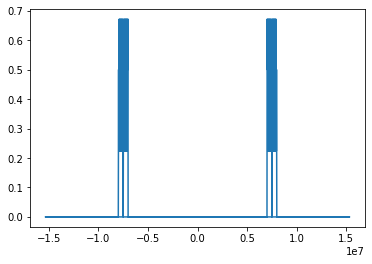

In [8]:
dft = np.fft.fft(txSignal)
freqs = np.fft.fftfreq(N, d=(1.0/(N*15000.0)))
dft = dft.reshape(N,)
dft = np.abs(dft)

plt.plot(freqs, dft)
plt.show()

In [9]:
# Rx side.
carrierRxI = np.cos((2.0*np.pi*k*n)/N)
carrierRxI = carrierRxI.reshape(1,N)

carrierRxQ = alpha*np.sin(((2.0*np.pi*k*n)/N) + beta)
carrierRxQ = carrierRxQ.reshape(1,N)

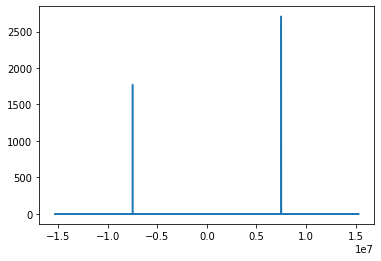

In [10]:
carrierRx = carrierRxI + 1j*carrierRxQ
dft = np.fft.fft(carrierRx)
freqs = np.fft.fftfreq(N, d=(1.0/(N*15000.0)))
dft = dft.reshape(N,)
dft = np.abs(dft)

plt.plot(freqs, dft)
plt.show()

In [11]:
yRxI = carrierRxI*txSignal
yRxQ = carrierRxQ*txSignal

y_imb = yRxI + 1j*yRxQ

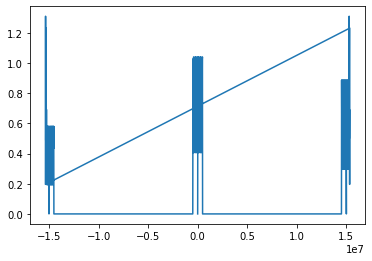

In [12]:
dft = np.fft.fft(y_imb)
freqs = np.fft.fftfreq(N, d=(1.0/(N*15000.0)))
dft = dft.reshape(N,)
dft = np.abs(dft)

plt.plot(freqs, dft)
plt.show()

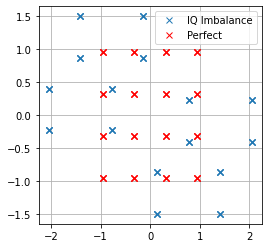

In [13]:
YRX = np.fft.fft(y_imb)
YRX = 2*np.c_[YRX[0,1:int(numSymbs/2)+1].reshape(1,int(numSymbs/2)), YRX[0,N-int(numSymbs/2):].reshape(1,int(numSymbs/2))]

plt.figure(figsize=(4,4))
plt.plot(YRX[0,:].real, YRX[0,:].imag, 'x', label='IQ Imbalance')
plt.plot(sig[0:modOrder].real.reshape(numSymbs,1), sig[0:modOrder].imag.reshape(numSymbs,1), 'rx', label='Perfect')
plt.grid()
plt.legend()
plt.show()

In [14]:
np.shape(y_imb)
np.shape(y_imb.real)
np.shape(y_imb.imag)

X = np.r_[y_imb.real, y_imb.imag]
np.shape(X)

W = np.array([[1, 0],[alpha*np.sin(beta), alpha*np.cos(beta)]])
np.shape(W)
print(W)
Winv = np.linalg.inv(W)
np.shape(Winv)
print(Winv)

yl = Winv.dot(X)
print(yl)
yl = yl[0,:] + 1j*yl[1,:]

yl = yl.reshape(1,N)

[[1.         0.        ]
 [1.73205081 1.        ]]
[[ 1.          0.        ]
 [-1.73205081  1.        ]]
[[ 0.00000000e+00 -8.98946523e-06 -8.14955491e-05 ... -7.62442033e-05
   1.58091192e-04 -8.82202982e-06]
 [ 0.00000000e+00 -2.44065515e-04  6.01147285e-06 ...  6.87517034e-04
   1.16615069e-05  2.39519615e-04]]


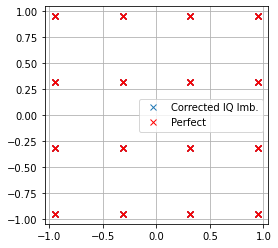

In [15]:
YRX = np.fft.fft(yl)
YRX = 2*np.c_[YRX[0,1:int(numSymbs/2)+1].reshape(1,int(numSymbs/2)), YRX[0,N-int(numSymbs/2):].reshape(1,int(numSymbs/2))]

plt.figure(figsize=(4,4))
plt.plot(YRX[0,:].real, YRX[0,:].imag, 'x', label='Corrected IQ Imb.')
plt.plot(sig[0:modOrder].real.reshape(numSymbs,1), sig[0:modOrder].imag.reshape(numSymbs,1), 'rx', label='Perfect')
plt.grid()
plt.legend()
plt.show()

In [16]:
carrierRxPerfectI = np.cos((2.0*np.pi*k*n)/N)
carrierRxPerfectI = carrierRxPerfectI.reshape(1,N)
carrierRxPerfectQ = np.sin((2.0*np.pi*k*n)/N)
carrierRxPerfectQ = carrierRxPerfectQ.reshape(1,N)

In [17]:
carrierRxPerfect = carrierRxPerfectI + 1j*carrierRxPerfectQ

y_per = txSignal*carrierRxPerfect

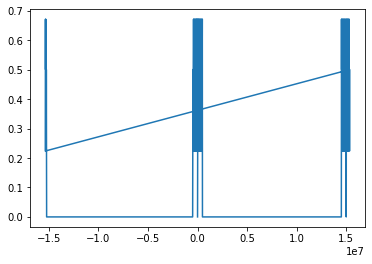

In [18]:
dft = np.fft.fft(y_per)
freqs = np.fft.fftfreq(N, d=(1.0/(N*15000.0)))
dft = dft.reshape(N,)
dft = np.abs(dft)

plt.plot(freqs, dft)
plt.show()

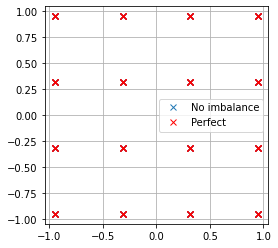

In [19]:
YRX = np.fft.fft(y_per)
YRX = 2*np.c_[YRX[0,1:int(numSymbs/2)+1].reshape(1,int(numSymbs/2)), YRX[0,N-int(numSymbs/2):].reshape(1,int(numSymbs/2))]

plt.figure(figsize=(4,4))
plt.plot(YRX[0,:].real, YRX[0,:].imag, 'x', label='No imbalance')
plt.plot(sig[0:modOrder].real.reshape(numSymbs,1), sig[0:modOrder].imag.reshape(numSymbs,1), 'rx', label='Perfect')
plt.grid()
plt.legend()
plt.show()

In [20]:
#I_hat,Q_hat,I,Q,Y
x1 = y_imb.real.T
x2 = y_imb.imag.T
X = np.c_[x1, x2]
y1 = y_per.real.T
y2 = y_per.imag.T
Y = y2

In [21]:
# Alpha
alpha = 1000

# Random initialization of parameters.
a = np.array([0.0, 0.0]).reshape(2, 1)

# Create lists for parameter history.
a0_hist,a1_hist = [],[]

# Create list for storing error values.
Jbgd = []

Jbgd.append((1.0/N)*sum(np.power(Y - X.dot(a), 2)))

# Batch gradient-descent loop.
iteration = 0
error = 1
grad_hist = []

while error > 1e-16:
    # Weight update.
    gradients = -(2.0/N)*X.T.dot(Y - X.dot(a))
    a = a - alpha * gradients
    # Calculate error.
    Jbgd.append((1.0/N)*sum(np.power((Y - X.dot(a)), 2)))
    # Error between iterations.
    error = np.abs(Jbgd[iteration+1] - Jbgd[iteration])
    # Store weight and gradient history.
    a0_hist.append(a[0])
    a1_hist.append(a[1])
    grad_hist.append(gradients)
    # Increment counter.
    iteration += 1
    print(a)

A saída de streaming foi truncada nas últimas 5000 linhas.
[[-1.72259995]
 [ 0.99566737]]
[[-1.72261488]
 [ 0.99567421]]
[[-1.7226298 ]
 [ 0.99568105]]
[[-1.72264469]
 [ 0.99568788]]
[[-1.72265956]
 [ 0.99569469]]
[[-1.7226744]
 [ 0.9957015]]
[[-1.72268922]
 [ 0.99570829]]
[[-1.72270402]
 [ 0.99571508]]
[[-1.72271879]
 [ 0.99572185]]
[[-1.72273354]
 [ 0.99572861]]
[[-1.72274827]
 [ 0.99573536]]
[[-1.72276298]
 [ 0.9957421 ]]
[[-1.72277766]
 [ 0.99574884]]
[[-1.72279231]
 [ 0.99575555]]
[[-1.72280695]
 [ 0.99576226]]
[[-1.72282156]
 [ 0.99576896]]
[[-1.72283615]
 [ 0.99577565]]
[[-1.72285071]
 [ 0.99578233]]
[[-1.72286525]
 [ 0.99578899]]
[[-1.72287977]
 [ 0.99579565]]
[[-1.72289427]
 [ 0.99580229]]
[[-1.72290874]
 [ 0.99580893]]
[[-1.72292319]
 [ 0.99581555]]
[[-1.72293762]
 [ 0.99582217]]
[[-1.72295202]
 [ 0.99582877]]
[[-1.72296641]
 [ 0.99583537]]
[[-1.72298077]
 [ 0.99584195]]
[[-1.7229951 ]
 [ 0.99584852]]
[[-1.72300942]
 [ 0.99585508]]
[[-1.72302371]
 [ 0.99586163]]
[[-1.72303797

In [22]:
# Print and verify linear regression (BGD) results.
print(Winv[1])
Winv[1] = a.T
print(a)
assert (abs(Winv[1] - a.T) < 1e-3).all()

[-1.73205081  1.        ]
[[-1.7318694 ]
 [ 0.99991684]]


In [23]:
# Generate values for parameters.
M = 100
a1 = np.linspace(-3.0, 3.0, M)
a2 = np.linspace(-3.0, 3.0, M)

A1, A2 = np.meshgrid(a1, a2)

# Generate points for plotting the cost-function surface.
J = np.zeros((M,M))
for iter1 in range(0, M):
    for iter2 in range(0, M):
        yhat = A1[iter1][iter2]*x1 + A2[iter1][iter2]*x2
        J[iter1][iter2] = (1.0/N)*np.sum(np.square(Y - yhat))

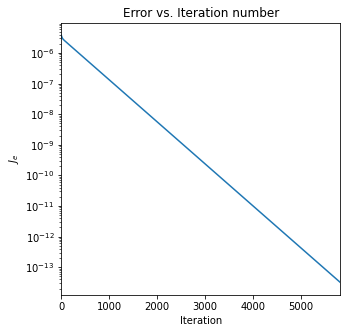

In [24]:
# Plot error vs iteration number.
fig = plt.figure(figsize=(8,8))
plt.plot(np.arange(0, iteration), Jbgd[0:iteration])
plt.xlim((0, iteration))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.savefig("error_vs_iteration.png", dpi=600)
plt.show()

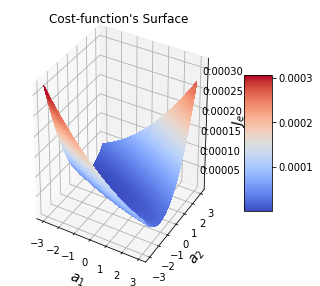

In [25]:
# Plot cost-function surface.
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(A1, A2, J, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$a_1$', fontsize=14)
ax.set_ylabel('$a_2$', fontsize=14)
ax.set_zlabel('$J_e$', fontsize=14);
plt.title('Cost-function\'s Surface')
plt.savefig("cost_function_contour.png", dpi=600)
plt.show()

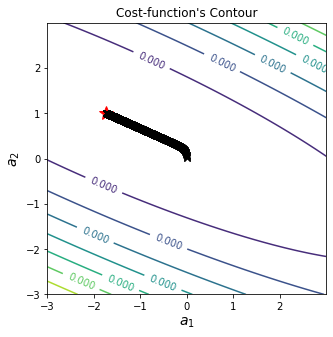

In [26]:
# Plot cost-function contour.        
fig = plt.figure(figsize=(10,5))
cp = plt.contour(A1, A2, J)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour')
plt.plot(Winv[1,0], Winv[1,1], c='r', marker='*', markersize=14)
plt.plot(a0_hist, a1_hist, 'kx')
plt.xticks(np.arange(-3, 3, step=1))
plt.yticks(np.arange(-3, 3, step=1))
plt.savefig("error_contour.png", dpi=600)
plt.show()

In [27]:
np.shape(y_imb)
np.shape(y_imb.real)
np.shape(y_imb.imag)

X = np.r_[y_imb.real, y_imb.imag]
np.shape(X)

line1 = np.array([1,0])
line2 = a.T.flatten()

matrix = np.c_[line1,line2].T

print(np.shape(matrix))
print(np.shape(X))

yl = matrix.dot(X)

yl = yl[0,:] + 1j*yl[1,:]
yl = yl.reshape(1,N)

(2, 2)
(2, 2048)


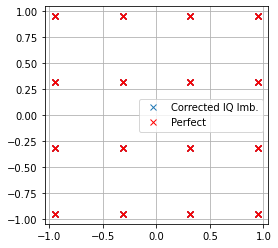

In [28]:
YRX = np.fft.fft(yl)
YRX = 2*np.c_[YRX[0,1:int(numSymbs/2)+1].reshape(1,int(numSymbs/2)), YRX[0,N-int(numSymbs/2):].reshape(1,int(numSymbs/2))]

plt.figure(figsize=(4,4))
plt.plot(YRX[0,:].real, YRX[0,:].imag, 'x', label='Corrected IQ Imb.')
plt.plot(sig[0:modOrder].real.reshape(numSymbs,1), sig[0:modOrder].imag.reshape(numSymbs,1), 'rx', label='Perfect')
plt.grid()
plt.legend()
plt.show()